**Malaria Detection Using Transfer Learning(VGG16)**

Malaria is a deadly, infectious mosquito-borne disease caused by plasmodium parasites. These parasites are transmitted by the bites of infected female Anopheles mosquitoes. Initially if an infected mosquito bites you, parasites carried by the mosquito will get in your blood and start destroying oxygen-carrying RBCs (red blood cells). Typically the first symptoms of malaria are similar to the flu or a virus when you usually start feeling sick within a few days or weeks after the mosquito bite. However these deadly parasites can live in your body for over a year without any problems! Thus, a delay in the right treatment can lead to complications and even death. Hence early and effective testing and detection of malaria can save lives. 


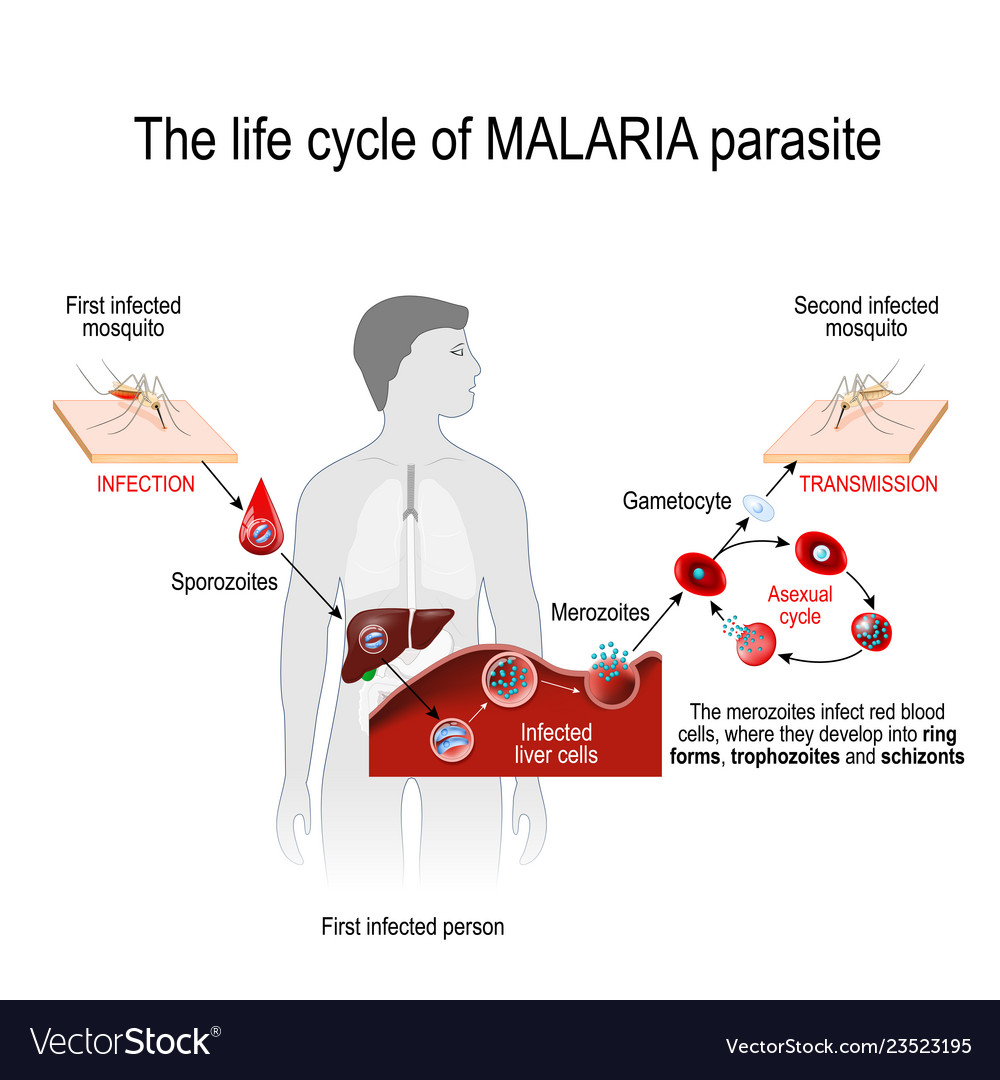

**Methods for Malaria Detection**

Based on the guidelines from the WHO protocol, the procedure involves intensive examination of the blood smear at a 100X magnification, where people manually count red blood cells that contain parasites out of 5000 cells.

Thick blood smears assist in detecting the presence of parasites while thin blood smears assist in identifying the species of the parasite causing the infection. The diagnostic accuracy heavily depends on human expertise and can be adversely impacted by the inter-observer variability and the liability imposed by large-scale diagnoses in disease-endemic/resource-constrained regions. Alternative techniques such as polymerase chain reaction (PCR) and rapid diagnostic tests (RDT) are used; however, PCR analysis is limited in its performance (Hommelsheim et al., 2014) and RDTs are less cost-effective in disease-endemic regions.

Thus, malaria detection is definitely an intensive manual process which can perhaps be automated using deep learning .

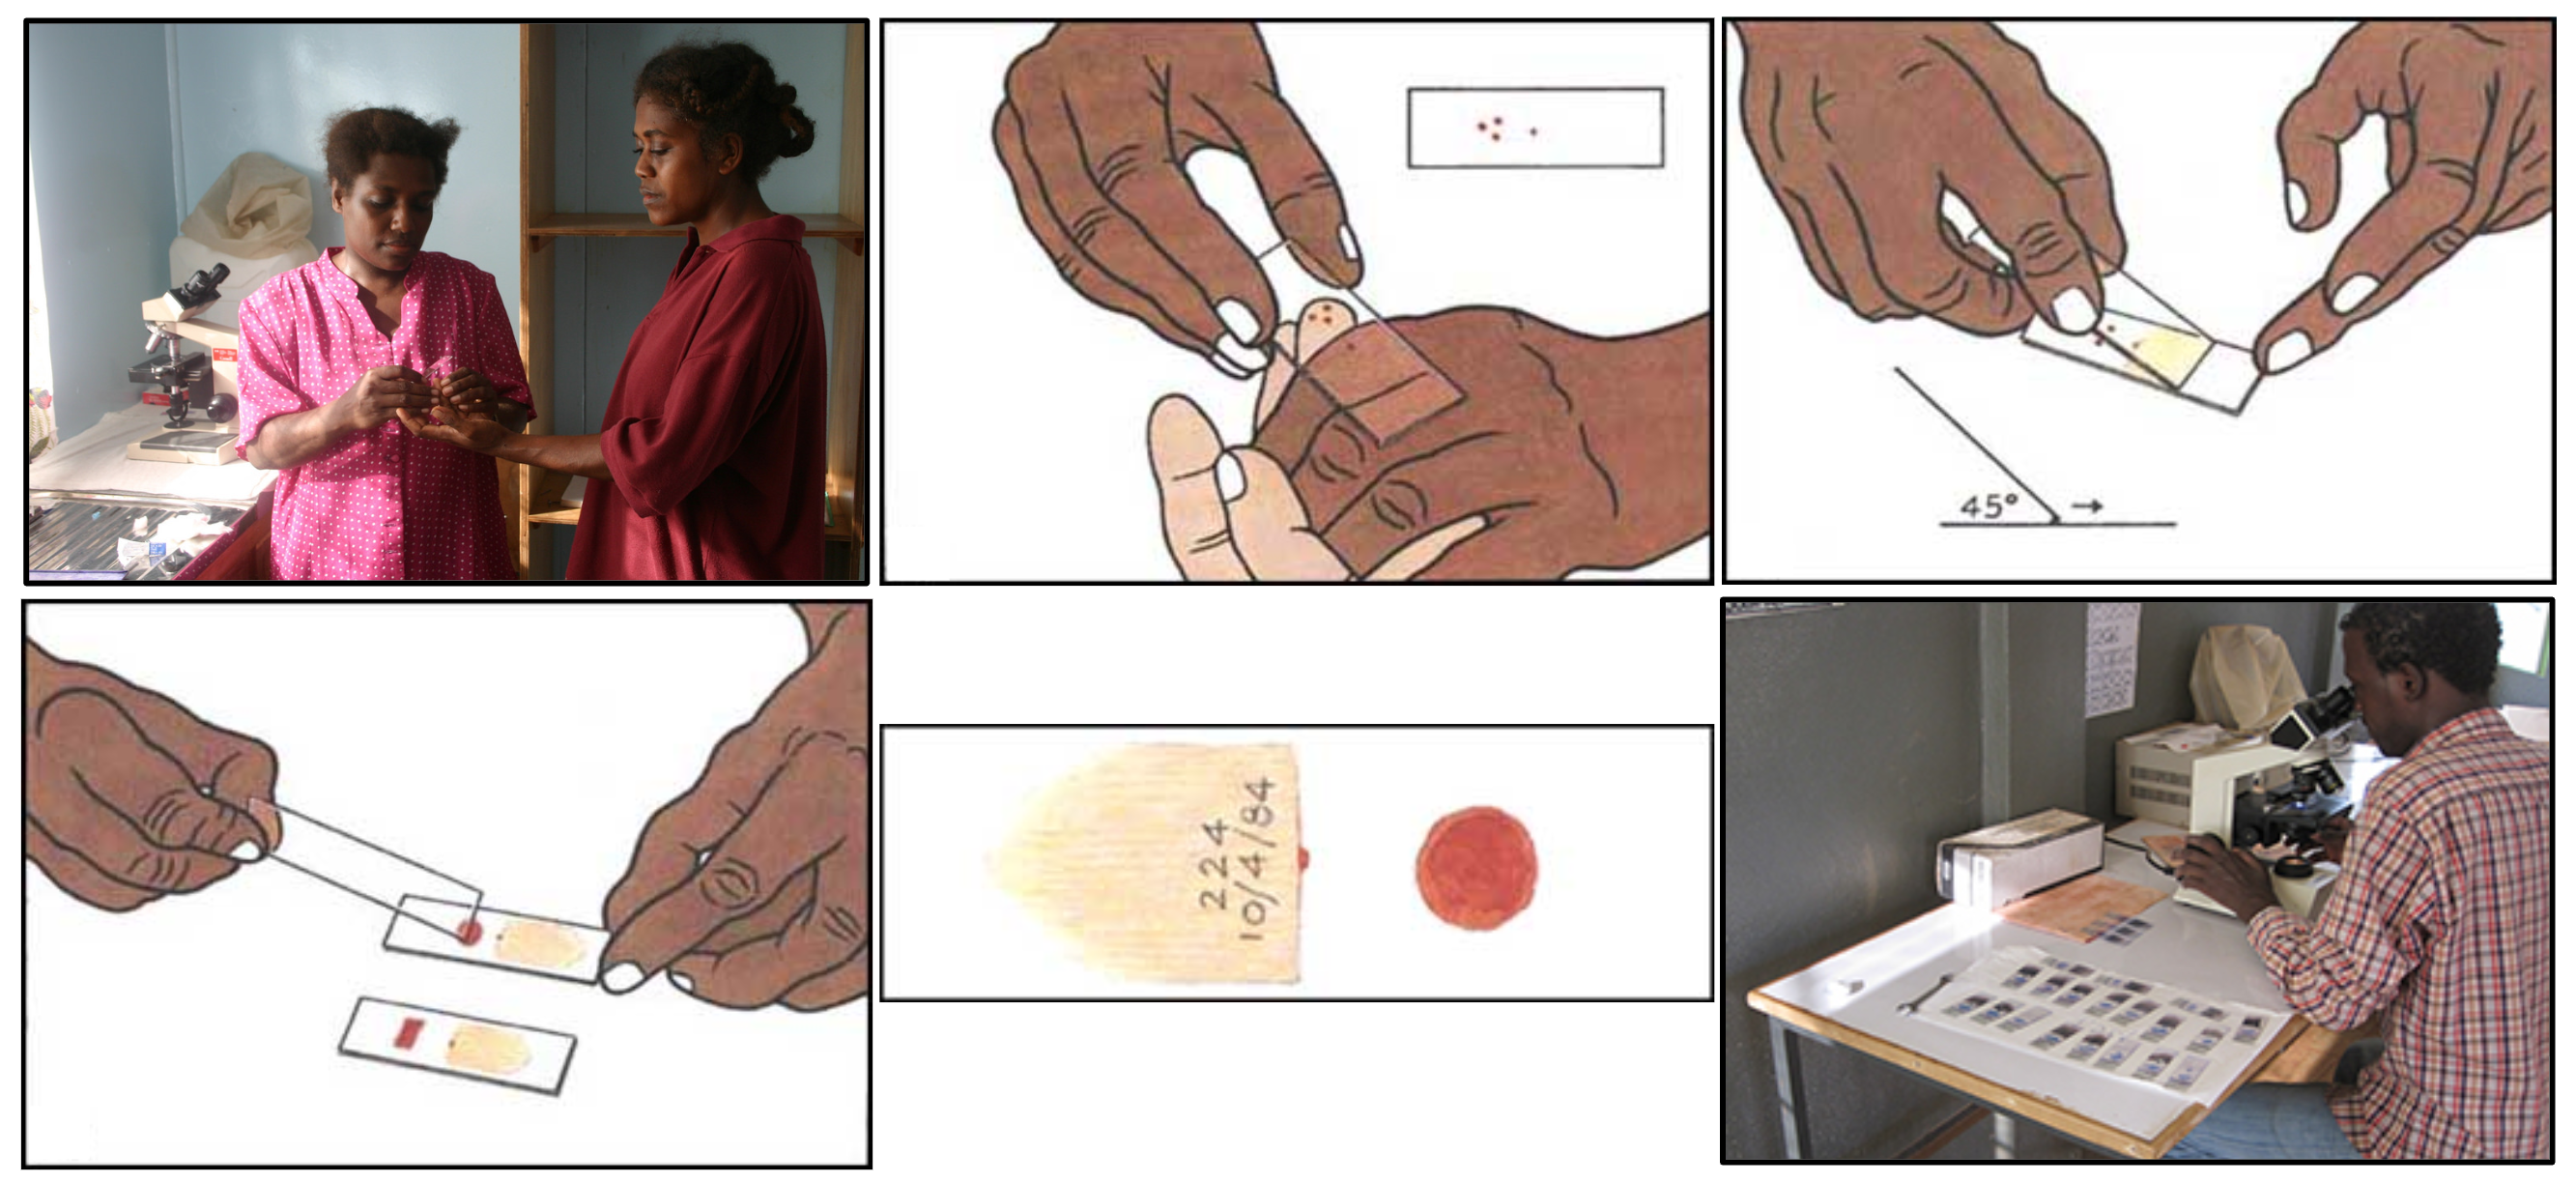

In [ ]:
# upload data form kaggle
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
 !pip install -q kaggle
 !mkdir -p ~/.kaggle
 !cp kaggle.json ~/.kaggle/
 !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

 99% 670M/675M [00:05<00:00, 149MB/s]
100% 675M/675M [00:05<00:00, 129MB/s]


In [ ]:
# unzip the data
from zipfile import ZipFile
file_name = 'cell-images-for-detecting-malaria.zip'

with ZipFile(file_name , 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
# function to visualize parasitized and uninfectious blood smear images 
import os
import matplotlib.pyplot as plt
labels = ['Parasitized','Uninfected']
def plot_img(path,n):
  for label in labels:
    img_path = os.path.join(path,label)
    x = os.listdir(img_path)
    plt.figure(figsize=(10,10))
    for i in range(n):
      plt.subplot(2,n,i+1)
      path_new = ''
      path_new = os.path.join(img_path,x[i])
      image = plt.imread(path_new)
      plt.imshow(image)
      plt.title(label)
      plt.axis('off')
    plt.show()

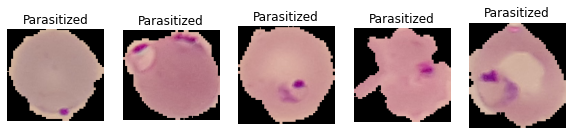

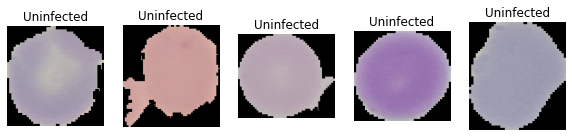

In [ ]:
plot_img('/content/cell_images',5)

In [ ]:
# Image Data Augmentation
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

In [ ]:
train_data = datagen.flow_from_directory('/content/cell_images/cell_images', subset='training',
                                         target_size = (224, 224))

Found 19292 images belonging to 2 classes.


In [ ]:
test_data = datagen.flow_from_directory('/content/cell_images/cell_images', subset = 'validation',
                                        shuffle = False,
                                        target_size = (224,224))

Found 8266 images belonging to 2 classes.


**VGG-16**

VGG-16 is one of the most popular pre-trained models for image classification. It was developed at the Visual Graphics Group at the university of oxford and introduced in the ILSVRC 2014 conference.


In [ ]:
#import the necessary libraries
import keras
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Flatten, Dropout, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Loading the VGG-16 base model
vgg16 = VGG16(input_shape=(224,224,3), include_top=False, weights='imagenet')

In [ ]:
# Making the vgg-16 layers non-trainable
for layer in vgg16.layers:
  layer.trainable = False

In [ ]:
# Flatten the output layer to 1 layer
x = Flatten()(vgg16.output)
# Add a fully connected layer with 512 hidden units with relu activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.3
x = Dropout(0.3)(x)
# Add a final softmax layer for classification
x = Dense(2, activation='softmax')(x)
# create model from inputs and outputs
model = Model(vgg16.input, x)
# compile the model 
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
# to review the summary of the model
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [ ]:
# Training a model
hist = model.fit(train_data, epochs=25, batch_size=32, callbacks=[EarlyStopping(monitor='val_loss',patience=10),
                                                                 ModelCheckpoint('Malaria_best_model.hdf5',monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')],
          validation_data=(test_data))

Epoch 1/25
603/603 [==============================] - ETA: 0s - loss: 0.4194 - accuracy: 0.8520
Epoch 00001: val_accuracy improved from -inf to 0.90213, saving model to Malaria_best_model.hdf5
603/603 [==============================] - 56s 92ms/step - loss: 0.4194 - accuracy: 0.8520 - val_loss: 0.2575 - val_accuracy: 0.9021
Epoch 2/25
603/603 [==============================] - ETA: 0s - loss: 0.2486 - accuracy: 0.9032
Epoch 00002: val_accuracy did not improve from 0.90213
603/603 [==============================] - 55s 92ms/step - loss: 0.2486 - accuracy: 0.9032 - val_loss: 0.2660 - val_accuracy: 0.8973
Epoch 3/25
603/603 [==============================] - ETA: 0s - loss: 0.2363 - accuracy: 0.9022
Epoch 00003: val_accuracy improved from 0.90213 to 0.91653, saving model to Malaria_best_model.hdf5
603/603 [==============================] - 56s 92ms/step - loss: 0.2363 - accuracy: 0.9022 - val_loss: 0.2316 - val_accuracy: 0.9165
Epoch 4/25
603/603 [==============================] - ETA: 0s

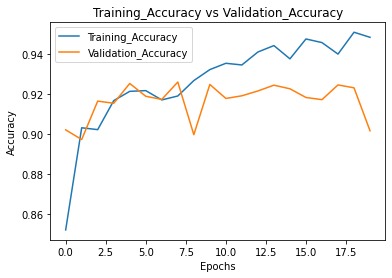

In [ ]:
# plotting training vs validation accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training_Accuracy','Validation_Accuracy'])
plt.title('Training_Accuracy vs Validation_Accuracy')
plt.show()

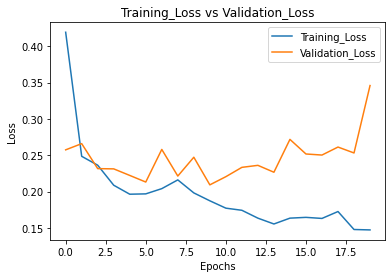

In [ ]:
# plotting training vs validation loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training_Loss','Validation_Loss'])
plt.title('Training_Loss vs Validation_Loss')
plt.show()

In [ ]:
# load the saved model
from keras.models import load_model
final_model = load_model('Malaria_best_model.hdf5')

In [ ]:
# estimate loss, accuracy for test_data
loss,acc = final_model.evaluate(test_data)
print('Model Loss:', loss)
print('Model Accuracy:',acc)

259/259 [==============================] - 17s 64ms/step - loss: 0.2214 - accuracy: 0.9261
Model Loss: 0.22135911881923676
Model Accuracy: 0.9260827302932739


In [ ]:
# Make prediction
pred =final_model.predict(test_data,verbose=1)

259/259 [==============================] - 16s 61ms/step


In [ ]:
# Identify the predicted classes from pred
import numpy as np
prediction = np.argmax(pred, axis=-1)

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y_true = test_data.classes, y_pred=prediction)

In [ ]:
# Function to plot confusion matrix
import itertools
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[3849  284]
 [ 327 3806]]


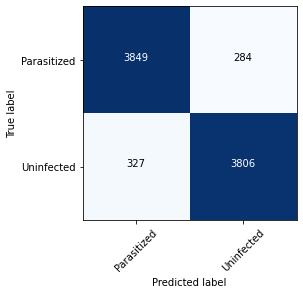

In [ ]:
# Visualizing confusion matrix graphically
cm_plot_labels = ['Parasitized', 'Uninfected']
plot_confusion_matrix(cm=conf, classes=cm_plot_labels, title='')

In [ ]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(y_true = test_data.classes, y_pred = prediction))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      4133
           1       0.93      0.92      0.93      4133

    accuracy                           0.93      8266
   macro avg       0.93      0.93      0.93      8266
weighted avg       0.93      0.93      0.93      8266



Our model has 93 % accuracy  and 0.93 f1-score while detecting malaria from blood smear images.